In [1]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
GaussianMix = GaussianMixture.symmetric_2D(4,1.0)

gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = BasicMLP(input_dim=2, hidden_dims=[64,64,64,64])

trainer = FlowDiffTrainer(path=gaussian_path, modeltype="Diffusion", model=model1)

trainer.train_loop(num_epochs=20000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 6.140861511230469
In Epoch 1000 we have a loss of 4.1362152099609375
In Epoch 2000 we have a loss of 6.86546516418457
In Epoch 3000 we have a loss of 8.19356918334961
In Epoch 4000 we have a loss of 12.2587308883667
In Epoch 5000 we have a loss of 8.298700332641602
In Epoch 6000 we have a loss of 7.219948768615723
In Epoch 7000 we have a loss of 5.525864124298096
In Epoch 8000 we have a loss of 12.043621063232422
In Epoch 9000 we have a loss of 11.373456001281738
In Epoch 10000 we have a loss of 7.891458988189697
In Epoch 11000 we have a loss of 5.576152801513672
In Epoch 12000 we have a loss of 5.2557573318481445
In Epoch 13000 we have a loss of 9.21939754486084
In Epoch 14000 we have a loss of 13.707091331481934
In Epoch 15000 we have a loss of 14.184674263000488
In Epoch 16000 we have a loss of 7.997416973114014
In Epoch 17000 we have a loss of 5.488241195678711
In Epoch 18000 we have a loss of 13.232792854309082
In Epoch 19000 we have a loss of 4.563098

In [3]:
rec1 = RectangleDataset(device=device, coords= [(-5.0,5.0),(-10,10)])

rec2 = RectangleDataset(device=device, coords =  [(-10,10), (-5.0,5.0)])

swiss = union_sample([rec1,rec2])

gaussian_path2 = GaussianConditionalProbabilityPath(p_data=swiss, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model2 = BasicMLP(input_dim=2, hidden_dims=[64,64,64,64])

trainer2 = FlowDiffTrainer(path=gaussian_path2, modeltype="Diffusion", model=model2)

trainer2.train_loop(num_epochs=20000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 7.340219497680664
In Epoch 1000 we have a loss of 11.834943771362305
In Epoch 2000 we have a loss of 18.796953201293945
In Epoch 3000 we have a loss of 5.253894805908203
In Epoch 4000 we have a loss of 8.334668159484863
In Epoch 5000 we have a loss of 13.759726524353027
In Epoch 6000 we have a loss of 5.866242408752441
In Epoch 7000 we have a loss of 12.043957710266113
In Epoch 8000 we have a loss of 43.726348876953125
In Epoch 9000 we have a loss of 7.453252792358398
In Epoch 10000 we have a loss of 10.817246437072754
In Epoch 11000 we have a loss of 6.502560615539551
In Epoch 12000 we have a loss of 7.719603538513184
In Epoch 13000 we have a loss of 14.28585433959961
In Epoch 14000 we have a loss of 6.970522880554199
In Epoch 15000 we have a loss of 4.339498043060303
In Epoch 16000 we have a loss of 6.8705220222473145
In Epoch 17000 we have a loss of 5.645781993865967
In Epoch 18000 we have a loss of 5.100104331970215
In Epoch 19000 we have a loss of 24.2

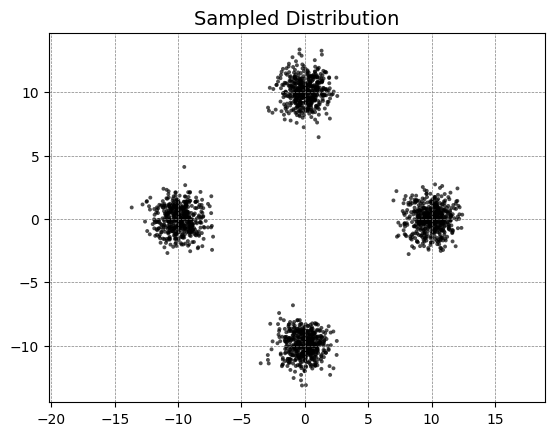

In [4]:
plot_samples(GaussianMix.sample(2000))
plt.show()

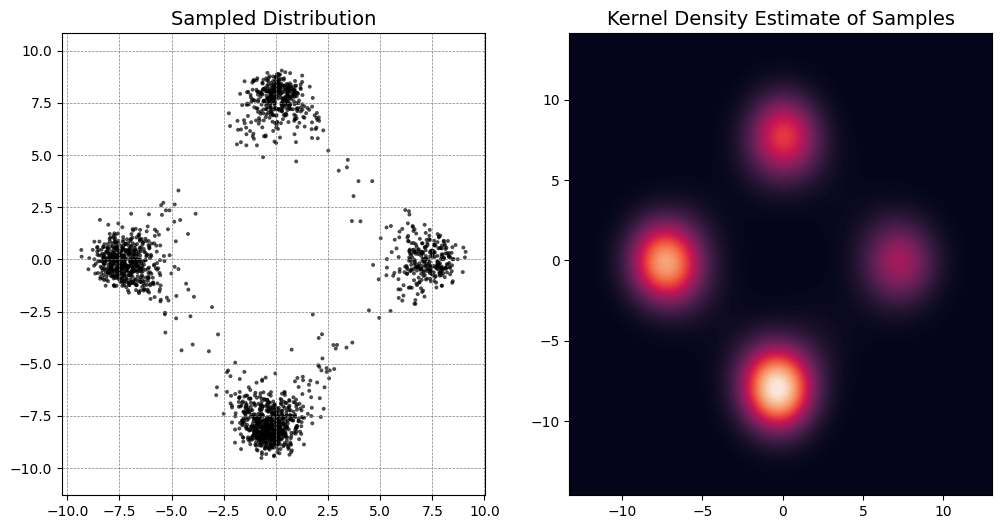

In [5]:
models = [model1,model2]

sde = CompLangevin(models=models, sigma = 0.5, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 
samples = comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps)
figsize=(12, 6)

fig, axes = plt.subplots(1, 2, figsize = figsize)
plot_samples(samples, ax=axes[0], kde=True)
plot_kde(samples, ax = axes[1], cmap="rocket")

plt.show()

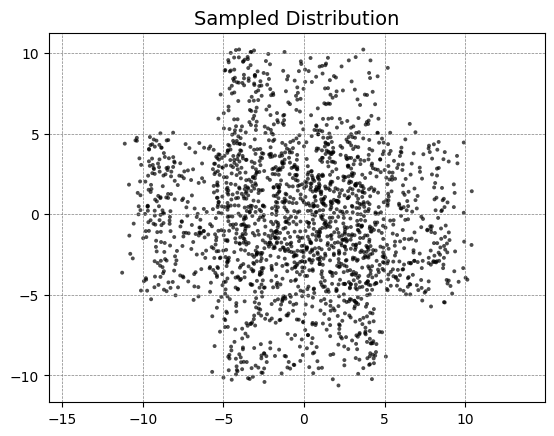

In [6]:
models = [model2]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.05, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps),contour=False)

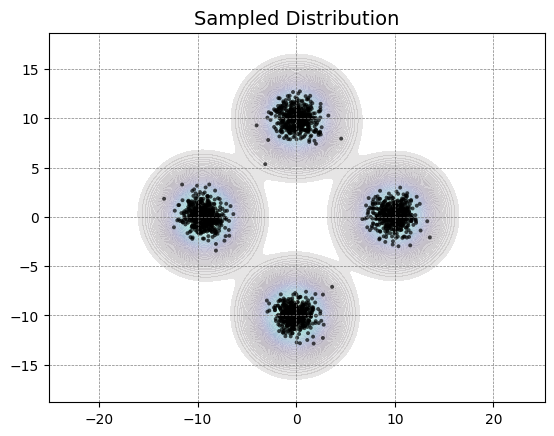

In [7]:
models = [model1]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_with_traj(gaussian_path.p_init.sample(2000), steps)[-1], scatter=True,kde=True)